# Creating block matrix structures using numpy and scipy

This notebook intends to provide a consistent way to create a block matrix structure from a simplified non-block matrix structure.

## Numpy (dense) version

First, let's import our numpy module

In [1]:
import numpy as np

Now, assuming we have the following matrix structure

In [2]:
A = np.array([[1, 1, 0, 0, 0, 0],
              [1, 1, 1, 0, 0, 0],
              [0, 1, 1, 1, 0, 0],
              [0, 0, 1, 1, 1, 0],
              [0, 0, 0, 1, 1, 1],
              [0, 0, 0, 0, 1, 1]])

In [3]:
A

array([[1, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1]])

We want to expand this structure to a block matrix structure for a given number of degrees of freedom (dof)

In [4]:
dof = 3

All we need is to define a blow matrix as follow

In [5]:
B = np.ones((dof, dof))

In [6]:
B

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

The Kronecker product (`kron`) of the matrix `A` with this matrix `B` will result in a block matrix with similar shape as `A`

In [7]:
A_block = np.kron(A, B)

For more info about the Kronecker product, check this [link](https://en.wikipedia.org/wiki/Kronecker_product).

Now let's view the resulting structure of our matrix by defining the following auxiliary plot method

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

def spy(A, precision=0.1, markersize=5, figsize=None):
    if figsize:
        fig = plt.figure(figsize=figsize)
    else:
        fig = plt.figure()
    plt.spy(A, precision=precision, markersize=markersize)
    plt.show()

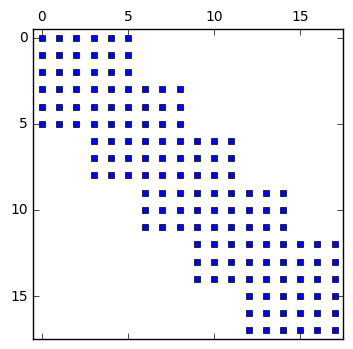

In [9]:
spy(A_block)

## Scipy (sparse) version

Let's import our `scipy.sparse` module

In [10]:
import scipy.sparse as sp

Let's create a simple sparse diagonal matrix.

In [11]:
N = 10

In [12]:
A = sp.diags([1, 1, 1], [-1, 0, 1], shape=(N, N))

The matrix `B` can be the same (dense) matrix. 

In [13]:
A_block_sparse = sp.kron(A, B)

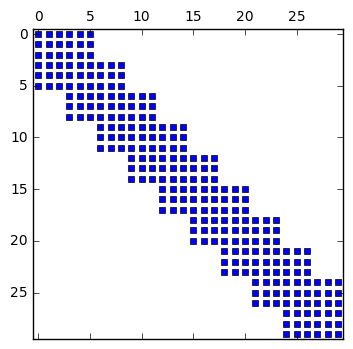

In [14]:
spy(A_block_sparse)

## The method `kronsum`

As a curiosity, the method `kronsum` has an interesting feature also, let's check it out

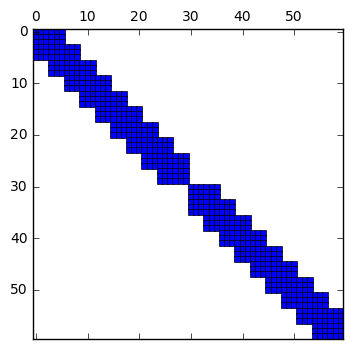

In [15]:
B = [[1, 0], [0, 1]]
A_new = sp.kronsum(A_block_sparse, B)
#A_new = sp.kronsum(A_block_sparse, [[1, 1, 1, 1], [1, 1, 1, 1 ], [1, 1, 1, 1], [1, 1, 1, 1]])

spy(A_new)

Inverting the product order

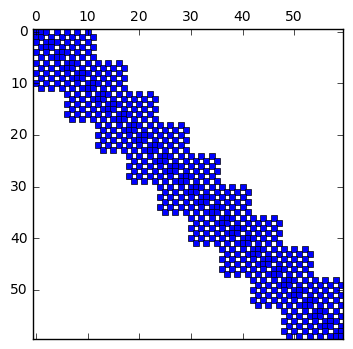

In [16]:
B = [[1, 1], [1, 1]]
A_new = sp.kronsum(B, A_block_sparse)

spy(A_new)

We can check the definition of the `kronsum` [here](http://mathworld.wolfram.com/KroneckerSum.html). I am not sure if it matches the `scipy` definition.

## Network case

Now for our network case, the matrix structure will be more complex. However, we now must simply define the non-blocked matrix structure. It will be much easier!

Let's use `networkx` to help out with graph generation.

In [17]:
import networkx as nx

G = nx.Graph()
G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(1,3)

With `networkx`, the matrix structure associated with the graph above is easily obtained by using the `laplacian_matrix` method. 

In [18]:
nx.laplacian_matrix(G).toarray()

array([[ 1, -1,  0,  0],
       [-1,  3, -1, -1],
       [ 0, -1,  1,  0],
       [ 0, -1,  0,  1]], dtype=int32)

I have inspected the method above, and it essentially uses the `to_scipy_sparse_matrix` (with a few extras sums), i.e.,

In [19]:
nx.to_scipy_sparse_matrix(G).toarray()

array([[0, 1, 0, 0],
       [1, 0, 1, 1],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=int32)

## Small problem

Let's start with a smaller problem

In [20]:
N = 3
A = sp.diags([1, 1, 1], [-1, 0, 1], shape=(N, N))
A.toarray()

array([[ 1.,  1.,  0.],
       [ 1.,  1.,  1.],
       [ 0.,  1.,  1.]])

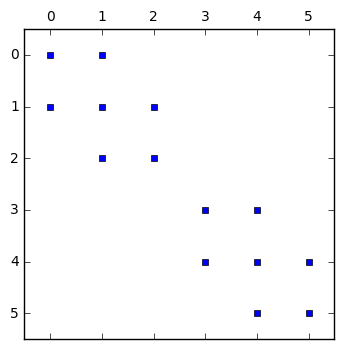

In [21]:
G = nx.Graph()
G.add_edge(0,1)
G.add_edge(1,2)

J = []
for pipe in G.edges():    
    A = sp.diags([1, 1, 1], [-1, 0, 1], shape=(N, N))
    J.append(A)
J = sp.block_diag(J)
spy(J)

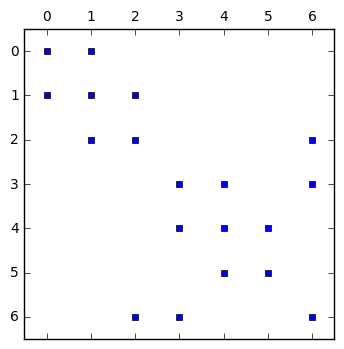

In [22]:
n_x = 3
connec = np.array([0, 1], dtype=int) + n_x - 1

B = np.zeros(J.shape[1])
B[connec] = 1

C = np.zeros((J.shape[0] + 1, 1))

C[connec, :] = 1
C[-1, :] = 1

J = sp.vstack([J, B])
J = sp.hstack([J, C])
spy(J)

Assuming that I have found my solution, the final block structure matrix is obtained simply by using `kron` product

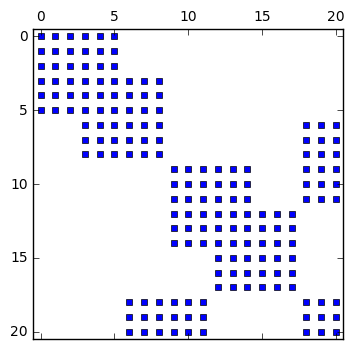

In [23]:
dof = 3
block = np.ones((dof, dof))
J_block = sp.kron(J, block)
spy(J_block)

![Alt text](https://img.memesuper.com/1164e63125beb13bced489740590bc1f_nice-meme-nice_319-316.jpeg)

...don't you think???

## More complex case

I wan't to assume that the isertion of edges and nodes in my graph matter. This is not the default behaviour in `networkx`. So the approach is to create a derived class that uses `OrderedDict` as factory.

In [24]:
from collections import OrderedDict

class OrderedDiGraph(nx.DiGraph):
    node_dict_factory      = OrderedDict
    adjlist_dict_factory   = OrderedDict
    edge_attr_dict_factory = OrderedDict
    
G = nx.OrderedDiGraph()
G.add_edge(0,1)
G.add_edge(1,2)
G.add_edge(1,3)
G.add_edge(3,4)
G.add_edge(4,5)
G.add_edge(3,6)

Let's use `draw` method from `networkx` to view our (pipe) network graph

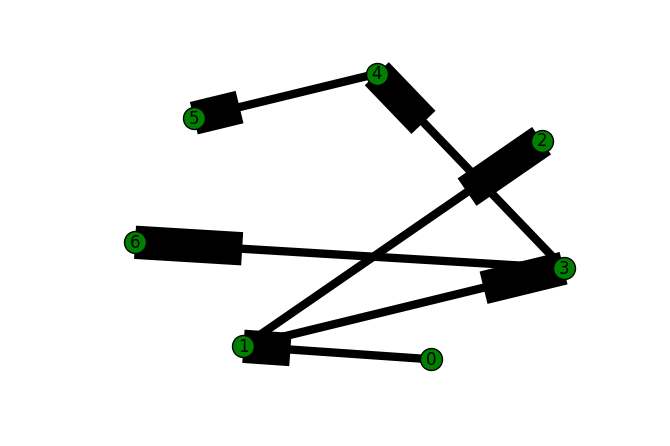

In [25]:
pos = nx.spring_layout(G, k=2)

plt.figure()
nx.draw(G, pos,node_color='g', node_size=250, with_labels=True, width=6)
plt.show()

The first step is to create the base matrix structure without including the internal nodes.

In [26]:
N = 10
J = []
edges_idx = {}
for i, pipe in enumerate(G.edges()):   
    edges_idx[pipe] = i
    A = sp.diags([1, 1, 1], [-1, 0, 1], shape=(N, N))
    J.append(A) 
J = sp.block_diag(J)

Ok.... so now a little warning. The code below is actually not so great, I wish I could do better, but there's no time left and this what I could come up with. What it does is: loop through all graph nodes, if it is an internal node, then add values to a connection list with the matrix positions where the values should be inserted. We only need an array for that since it will be a symmetric insertion along rows and columns.

In [27]:
connections = []
# Add internal node matrix structures
for n in G.nodes():  
    edges = G.in_edges(n) + G.out_edges(n)

    if len(edges) > 1:  # if len(edges) > 1, then n is an internal node       
        connec = []
        for i, e in enumerate(edges):
            j = edges_idx[e]             
            if e[0] == n:
                matrix_idx = j*N                 
            else:
                assert e[1] == n, 'node must match edge idx here!'
                matrix_idx = (j+1)*N - 1        
            connec.append(matrix_idx)            
        connections.append(connec)

The method defined below will help us to modify the shape of `J` by including the **nodes** in the end.

In [28]:
def append_connection_nodes_to_sparse_matrix(connec, J):
    B = np.zeros(J.shape[1])
    B[connec] = 1
    C = np.zeros((J.shape[0] + 1, 1))
    C[connec, :] = 1
    C[-1, :] = 1
    J = sp.vstack([J, B])
    J = sp.hstack([J, C])
    return J

Now let's modify our matrix with the method we have just implemented above

In [29]:
for connec in connections:
    J = append_connection_nodes_to_sparse_matrix(connec, J)

Nice, now it's time to view some results a see how it looks like. 

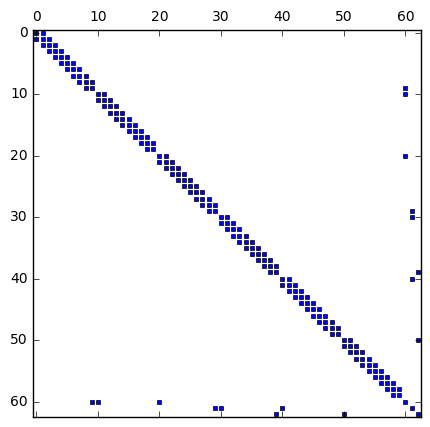

In [30]:
spy(J, markersize=3, figsize=(5,5))

Now let's use our magic `kron` (not so magic after you understand the mathematical definition) product to create the block matrix structure.

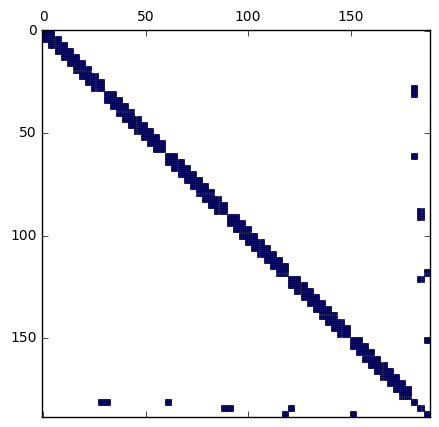

In [31]:
dof = 3
block = np.ones((dof, dof))
J_block = sp.kron(J, block)
spy(J_block, markersize=2, figsize=(5,5))

Bigger version (zoom) of the plot above...

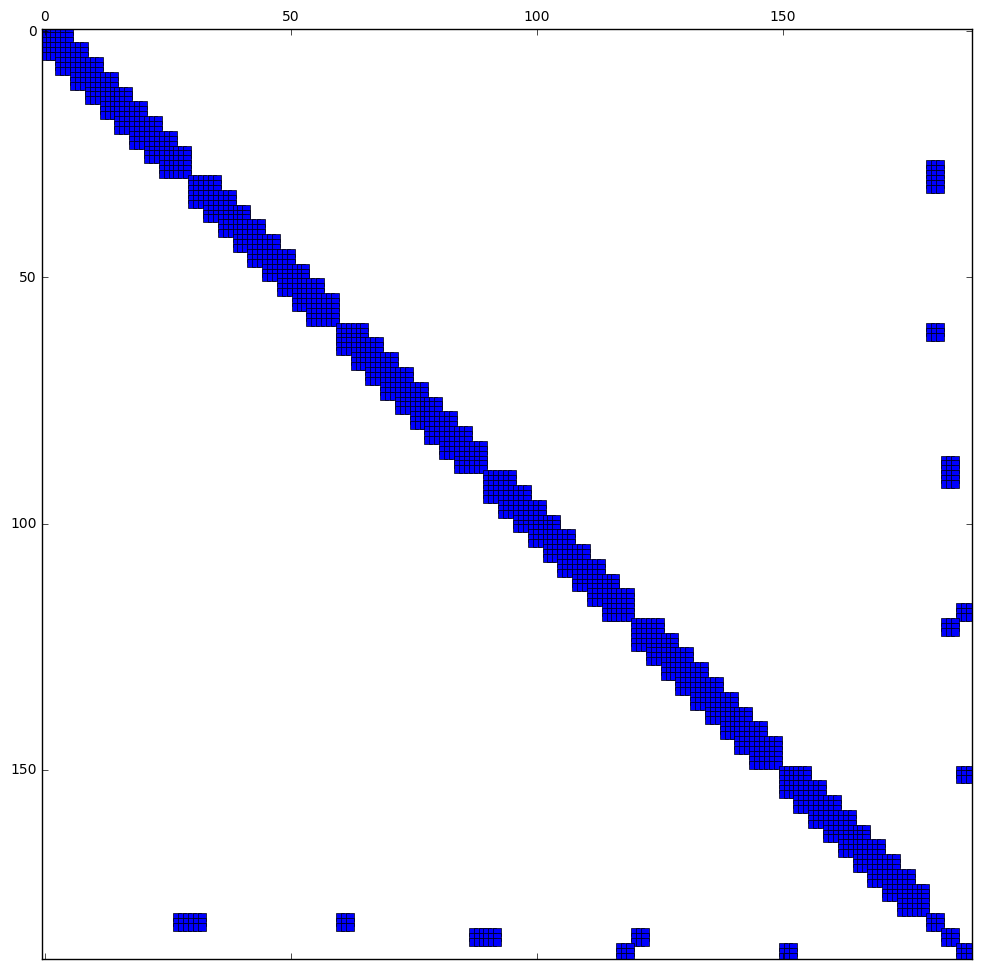

In [32]:
spy(J_block, markersize=5.05, figsize=(12,12))

![alt-text](https://img.memesuper.com/14119e421d296068f5ff53a4bf7ed427_the-end-of-the-school-year-is-end-memes_1024-773.jpeg)